# Modelo de solo texto — mejora con stopwords y explicación TF-IDF×coef

In [ ]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, f1_score

RANDOM_STATE = 42
def find_project_root(start: Path = None) -> Path:
    p = start or Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "data" / "raw").exists():
            return cand
    raise FileNotFoundError("No se encontró la carpeta 'data/raw' en la jerarquía del proyecto.")

PROJECT_ROOT = find_project_root()
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed" / "startups_sintetico_1000_processed.csv"

df = pd.read_csv(DATA_PROCESSED, encoding="utf-8")
assert {"descripcion","viabilidad"}.issubset(df.columns), "Faltan columnas 'descripcion' y/o 'viabilidad'."
X_text = df["descripcion"].astype(str)
y = df["viabilidad"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (800,) Test: (200,)


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

STOP_ES = {
    "a","ante","bajo","con","contra","de","desde","durante","en","entre","hacia",
    "hasta","para","por","según","sin","sobre","tras","el","la","los","las","un",
    "una","unos","unas","lo","al","del","y","o","u","e","que","se","su","sus",
    "es","son","ser","fue","han","ha","como","más","menos","muy","ya","no","sí",
    "si","pero","también","porque","cuando","este","esta","estos","estas"
}

pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=800,
        ngram_range=(1,2),
        min_df=2,
        stop_words=list(STOP_ES),
        token_pattern=r'(?u)\b[\wáéíóúñ]{3,}\b',
        sublinear_tf=True,
        max_df=0.95
    )),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

AUC: 0.521227621483376
              precision    recall  f1-score   support

           0      0.404     0.247     0.307        85
           1      0.568     0.730     0.639       115

    accuracy                          0.525       200
   macro avg      0.486     0.489     0.473       200
weighted avg      0.498     0.525     0.498       200

Matriz @0.5:
 [[21 64]
 [31 84]]


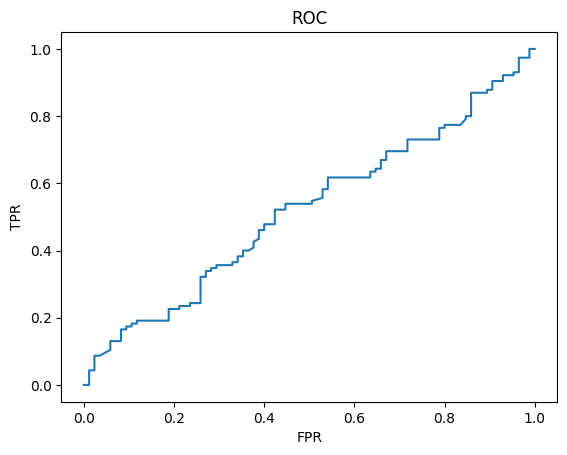

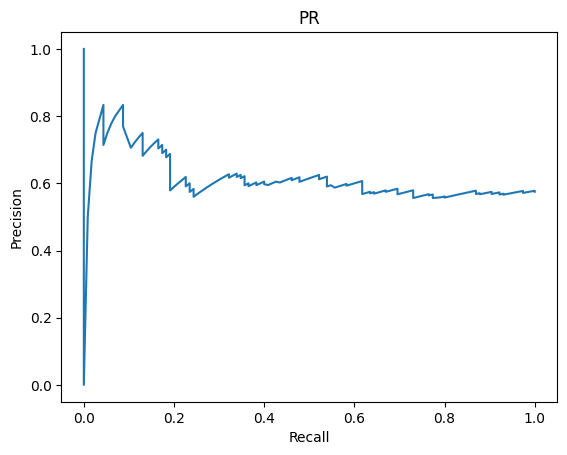

In [14]:
pipe.fit(X_train, y_train)

proba = pipe.predict_proba(X_test)[:, 1]
pred05 = (proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred05, digits=3))
print("Matriz @0.5:\n", confusion_matrix(y_test, pred05))

fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr); plt.title("ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

pr, rc, _ = precision_recall_curve(y_test, proba)
plt.plot(rc, pr); plt.title("PR"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

In [15]:
from joblib import dump
models_dir = Path("../models") if Path.cwd().name == "notebooks" else Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
dump(pipe, models_dir / "modelo_texto.joblib")
print("✅ Modelo guardado en:", models_dir / "modelo_texto.joblib")

✅ Modelo guardado en: ..\models\modelo_texto.joblib


In [16]:
import re, numpy as np

vec = pipe.named_steps["tfidf"]
model = pipe.named_steps["clf"]

def predecir_texto(descripcion: str, thr: float = 0.5, topk: int = 5):
    proba = float(pipe.predict_proba([descripcion])[0, 1])
    yhat = proba >= thr

    # Contribución por término = tfidf(texto) * coeficiente
    X1 = vec.transform([descripcion])
    contrib = X1.multiply(model.coef_)  # (1, n_features)
    contrib = np.asarray(contrib.todense()).ravel()
    feats = vec.get_feature_names_out()

    candidatos = []
    for i, c in enumerate(contrib):
        if c <= 0:
            continue
        t = feats[i]
        if len(t) < 3 or t in STOP_ES:
            continue
        if re.fullmatch(r"[a-záéíóúñ0-9\- ]+", t) is None:
            continue
        candidatos.append((t, c))

    candidatos.sort(key=lambda x: x[1], reverse=True)
    top = candidatos[:topk]
    just = "; ".join([f"{t}:{w:.3f}" for t, w in top]) if top else "(sin señales específicas útiles)"

    return {"probabilidad": proba, "viable": bool(yhat), "justificacion": f"Aportes: {just}"}

# Ejemplo
ej = "MRR mensual 10k usd, clientes activos y acuerdos B2B; equipo con 6 años en logística."
print("Ejemplo:", predecir_texto(ej))

Ejemplo: {'probabilidad': 0.38436884981130004, 'viable': False, 'justificacion': 'Aportes: equipo años:0.138; equipo:0.128; años:0.104; mrr:0.027; mensual:0.024'}
